## Agrupación de IPs por sus palabras clave

Paso 1: Cargar el dataset

In [1]:
import pandas as pd

df = pd.read_csv("Keywords/author_keyword_matrix.csv", index_col=0)

# Mostrar resumen
print("✅ Dataset generado con forma:", df.shape)
print("🔢 Palabras clave totales:", len(df.columns))
print("👥 Autores con keywords:", len(df))

✅ Dataset generado con forma: (29, 3329)
🔢 Palabras clave totales: 3329
👥 Autores con keywords: 29


Paso 2: Preprocesamiento (normalización y reducción PCA)

In [2]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

X = df.values
X_normalized = Normalizer().fit_transform(X)

Paso 3: Clustering con HDBSCAN

In [3]:
# === Configuraciones de preprocesamiento y clustering ===
pca_dims = [2, 5, 10, 20]
min_cluster_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan

# Evaluar KMeans para k entre 2 y 15
results = []

for n_dim in pca_dims:
    X_reduced = PCA(n_components=n_dim).fit_transform(X_normalized)

    for min_clust in min_cluster_sizes:
        try:
            model = hdbscan.HDBSCAN(min_cluster_size=min_clust)
            labels = model.fit_predict(X_reduced)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette = silhouette_score(X_reduced, labels)
                ch_score = calinski_harabasz_score(X_reduced, labels)
                db_score = davies_bouldin_score(X_reduced, labels)
            else:
                silhouette = ch_score = db_score = np.nan

            results.append({
                "PCA_dims": n_dim,
                "min_cluster_size": min_clust,
                "Clusters": n_clusters,
                "Silhouette": silhouette,
                "Calinski-Harabasz": ch_score,
                "Davies-Bouldin": db_score,
                "Labels": labels
            })

        except Exception as e:
            results.append({
                "PCA_dims": n_dim,
                "min_cluster_size": min_clust,
                "Clusters": 0,
                "Silhouette": np.nan,
                "Calinski-Harabasz": np.nan,
                "Davies-Bouldin": np.nan,
                "Error": str(e),
                "Labels": []
            })

df_results = pd.DataFrame(results).dropna(subset=["Silhouette"])
print("✅ Resultados generados:", df_results.shape)
print("🔍 Resultados de clustering:", df_results)

c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

✅ Resultados generados: (8, 7)
🔍 Resultados de clustering:     PCA_dims  min_cluster_size  Clusters  Silhouette  Calinski-Harabasz  \
0          2                 2         4    0.512205          26.283591   
1          2                 3         4    0.511506          29.089492   
9          5                 2         3    0.268425           3.559877   
10         5                 3         3    0.219450           3.243155   
11         5                 4         2    0.253196           4.287936   
18        10                 2         3    0.211927           3.785639   
19        10                 3         2    0.114747           2.931802   
27        20                 2         3    0.048848           2.099212   

    Davies-Bouldin                                             Labels  
0         1.169487  [3, -1, -1, 2, -1, 1, 3, 0, 2, 2, 1, 0, 0, 1, ...  
1         0.961389  [3, -1, -1, 2, -1, -1, 3, 0, 2, 2, -1, 0, 0, 1...  
9         3.296011  [1, -1, -1, -1, -1, 1, 1, 2, 

In [5]:
## Seleccionar mejores configuraciones por número de clusters
from sklearn.preprocessing import MinMaxScaler

print(df_results.head())
metrics = df_results[["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]].copy()
metrics["Davies-Bouldin"] = -metrics["Davies-Bouldin"]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(metrics), columns=metrics.columns)

df_results["score_combined"] = (
    0.8 * scaled["Silhouette"] +
    0.1 * scaled["Calinski-Harabasz"] +
    0.1 * scaled["Davies-Bouldin"]
)

best_per_ncluster = (
    df_results
    .sort_values("score_combined", ascending=False)
    .drop_duplicates(subset=["Clusters"])
    .sort_values("Clusters")
)

print("✅ Mejores configuraciones por número de clusters:")
print(best_per_ncluster[["PCA_dims", "min_cluster_size", "Clusters", "Silhouette", "score_combined"]])

    PCA_dims  min_cluster_size  Clusters  Silhouette  Calinski-Harabasz  \
0          2                 2         4    0.512205          26.283591   
1          2                 3         4    0.511506          29.089492   
9          5                 2         3    0.268425           3.559877   
10         5                 3         3    0.219450           3.243155   
11         5                 4         2    0.253196           4.287936   

    Davies-Bouldin                                             Labels  
0         1.169487  [3, -1, -1, 2, -1, 1, 3, 0, 2, 2, 1, 0, 0, 1, ...  
1         0.961389  [3, -1, -1, 2, -1, -1, 3, 0, 2, 2, -1, 0, 0, 1...  
9         3.296011  [1, -1, -1, -1, -1, 1, 1, 2, -1, -1, -1, -1, -...  
10        3.135296  [1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, ...  
11        3.804592  [0, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, ...  
✅ Mejores configuraciones por número de clusters:
    PCA_dims  min_cluster_size  Clusters  Silhouette  score_combine

Visualizamos las configuraciones

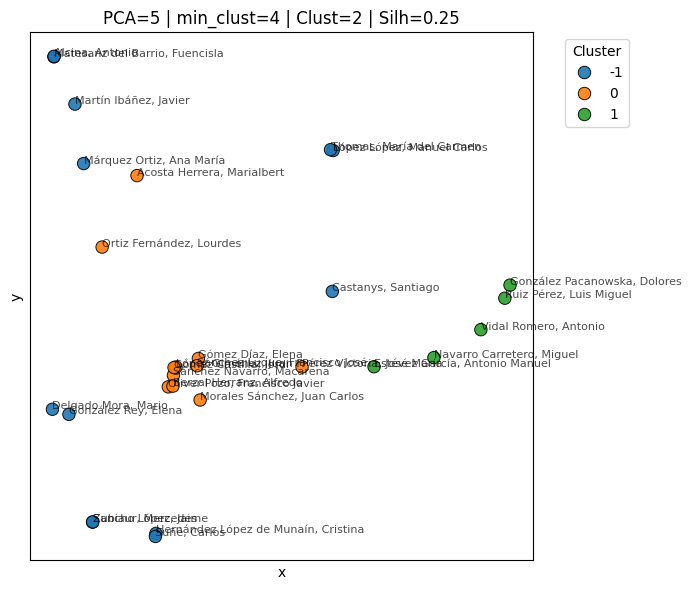

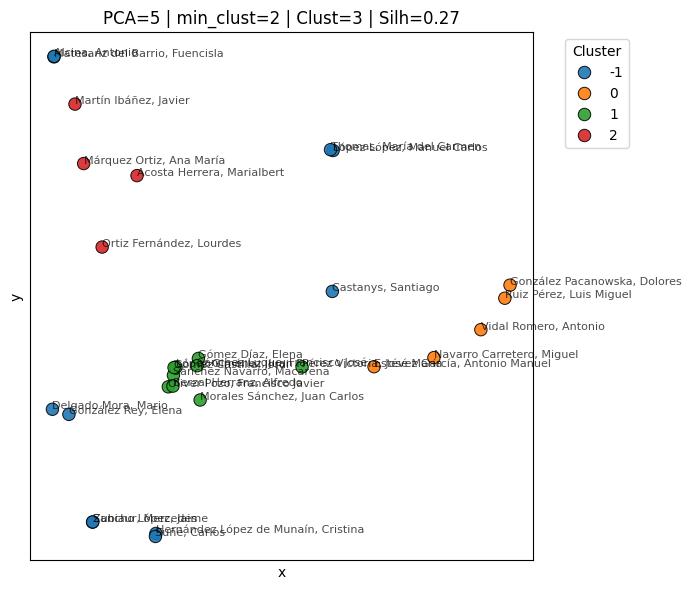

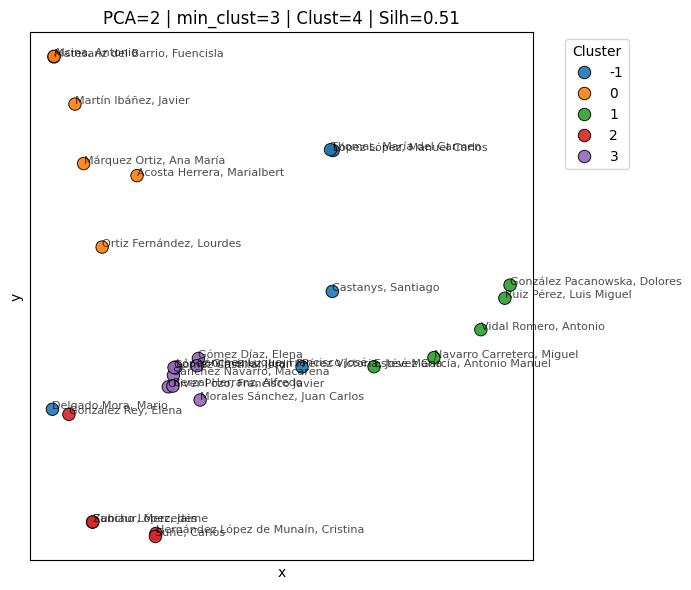

In [6]:
## Visualización de las configuraciones óptimas
X_2d = PCA(n_components=2).fit_transform(X_normalized)

for _, row in best_per_ncluster.iterrows():
    labels = row["Labels"]
    coords_df = pd.DataFrame(X_2d, columns=["x", "y"])
    coords_df["author"] = df.index
    coords_df["cluster"] = labels

    plt.figure(figsize=(7, 6), dpi=100)
    sns.scatterplot(
        data=coords_df,
        x="x", y="y",
        hue="cluster",
        palette="tab10",
        s=80,
        edgecolor='k',
        alpha=0.9
    )

    for _, r in coords_df.iterrows():
        plt.text(r["x"], r["y"], r["author"], fontsize=8, alpha=0.7)

    plt.title(f"PCA={row['PCA_dims']} | min_clust={row['min_cluster_size']} | Clust={row['Clusters']} | Silh={row['Silhouette']:.2f}")
    plt.xticks([]); plt.yticks([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Guardamos los resultados

In [7]:
## Guardar resultados
cluster_records = []

for _, row in best_per_ncluster.iterrows():
    labels = row["Labels"]
    n_clusters = row["Clusters"]
    pca_dims = row["PCA_dims"]
    silhouette = row["Silhouette"]
    ch_score = row["Calinski-Harabasz"]
    db_score = row["Davies-Bouldin"]
    min_clust = row["min_cluster_size"]

    for author, cluster in zip(df.index, labels):
        cluster_records.append({
            "author": author,
            "cluster": int(cluster),
            "n_clusters": n_clusters,
            "pca_dims": pca_dims,
            "min_cluster_size": min_clust,
            "silhouette": silhouette,
            "calinski_harabasz": ch_score,
            "davies_bouldin": db_score
        })

df_clusters_export = pd.DataFrame(cluster_records)
df_clusters_export.to_csv("Keywords/HDBSCAN/hdbscan_best_configs.csv", index=False)
print("✅ Resultados HDBSCAN guardados en CSV.")

✅ Resultados HDBSCAN guardados en CSV.
